In [1]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/01.\ 강의/2023.03 Big Data/12. DB on Python/codes
!pwd
!ls

/content/drive/MyDrive/01. 강의/2023.03 Big Data/12. DB on Python/codes
/content/drive/MyDrive/01. 강의/2023.03 Big Data/12. DB on Python/codes
'12-1. SQLight.ipynb'		   data		        test.csv
'12-2. MariaDB intro.ipynb'	   Investar	        Untitled0.ipynb
'12-3. DB_save_on_crawled.ipynb'  'sqlite 실습.ipynb'


In [4]:
import pymysql
import pandas as pd
from bs4 import BeautifulSoup
import pymysql, calendar, time, json
import requests
from datetime import date, datetime, timezone, timedelta
from threading import Timer

In [5]:
host="34.22.82.216"
port=3306
db="TEST_STOCK"
user="ktlim"
passwd="password"

In [6]:
conn = pymysql.connect(host=host, user=user, password=passwd, db=db, charset='utf8')

## 날짜 단위로 주식시세 스크래핑하기

In [7]:
with conn.cursor() as curs:
  sql = """
  CREATE TABLE IF NOT EXISTS company_info (
      code VARCHAR(20),
      company VARCHAR(40),
      last_update DATE,
      PRIMARY KEY (code))
  """
  curs.execute(sql)
  sql = """
  CREATE TABLE IF NOT EXISTS daily_price (
      code VARCHAR(20),
      date DATE,
      open BIGINT(20),
      high BIGINT(20),
      low BIGINT(20),
      close BIGINT(20),
      diff BIGINT(20),
      volume BIGINT(20),
      PRIMARY KEY (code, date))
  """
  curs.execute(sql)
  curs.close()

In [16]:
with conn.cursor() as curs:
  sql = """
  SELECT * FROM daily_price;
  """
  curs.execute(sql)
  rows = curs.fetchall()
  print(rows)

  curs.execute(sql)
  row = curs.fetchone()
  while row:
    print(row)
    row = curs.fetchone()
  # cursor 닫기
  curs.close()

(('251270', datetime.date(2023, 2, 20), 59300, 62600, 58900, 62000, 2800, 355719), ('251270', datetime.date(2023, 2, 21), 61300, 62700, 61000, 61900, 100, 193011), ('251270', datetime.date(2023, 2, 22), 61200, 61800, 59700, 59700, 2200, 220521), ('251270', datetime.date(2023, 2, 23), 60200, 66700, 60000, 64600, 4900, 953363), ('251270', datetime.date(2023, 2, 24), 63700, 64300, 62300, 63000, 1600, 312904), ('251270', datetime.date(2023, 2, 27), 62200, 62700, 60700, 61600, 1400, 214313), ('251270', datetime.date(2023, 2, 28), 61700, 63500, 61300, 61800, 200, 235725), ('251270', datetime.date(2023, 3, 2), 61800, 62000, 60000, 60900, 900, 198054), ('251270', datetime.date(2023, 3, 3), 61100, 61700, 59800, 60400, 500, 185452), ('251270', datetime.date(2023, 3, 6), 60900, 62200, 60400, 61200, 800, 168153), ('251270', datetime.date(2023, 3, 7), 60800, 61400, 59900, 60000, 1200, 171632), ('251270', datetime.date(2023, 3, 8), 59600, 59800, 58300, 58800, 1200, 194007), ('251270', datetime.date(

In [9]:
def read_naver_daily(code, company, pages_to_fetch): #taken from https://github.com/INVESTAR/StockAnalysisInPython
  """네이버에서 주식 시세를 읽어서 데이터프레임으로 반환"""
  try:
      url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
      html = BeautifulSoup(requests.get(url,
          headers={'User-agent': 'Mozilla/5.0'}).text, "lxml")
      pgrr = html.find("td", class_="pgRR")
      if pgrr is None:
          return None
      s = str(pgrr.a["href"]).split('=')
      lastpage = s[-1] 
      df = pd.DataFrame()
      pages = min(int(lastpage), pages_to_fetch)
      for page in range(1, pages + 1):
          pg_url = '{}&page={}'.format(url, page)                               
          df = df.append(pd.read_html(requests.get(pg_url,
              headers={'User-agent': 'Mozilla/5.0'}).text)[0])  
          tmnow = datetime.now().strftime('%Y-%m-%d %H:%M')
          print('[{}] {} ({}) : {:04d}/{:04d} pages are downloading...'.
              format(tmnow, company, code, page, pages), end="\r")
      df = df.rename(columns={'날짜':'date','종가':'close','전일비':'diff'
          ,'시가':'open','고가':'high','저가':'low','거래량':'volume'})
      df['date'] = df['date'].replace('.', '-')
      df = df.dropna()
      df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close',
          'diff', 'open', 'high', 'low', 'volume']].astype(int)
      df = df[['date', 'open', 'high', 'low', 'close', 'diff', 'volume']]
  except Exception as e:
      print('Exception occured :', str(e))
      return None
  return df

In [10]:
def replace_into_db(df, num, code, company):
  """네이버에서 읽어온 주식 시세를 DB에 REPLACE"""
  with conn.cursor() as curs:
      for r in df.itertuples():
          sql = f"REPLACE INTO daily_price VALUES ('{code}', "\
              f"'{r.date}', {r.open}, {r.high}, {r.low}, {r.close}, "\
              f"{r.diff}, {r.volume})"
          curs.execute(sql)
      conn.commit()
      print('[{}] #{:04d} {} ({}) : {} rows > REPLACE INTO daily_'\
          'price [OK]'.format(datetime.now().strftime('%Y-%m-%d'\
          ' %H:%M'), num+1, company, code, len(df)))

In [11]:
df = read_naver_daily(251270, "넷마블", 3)

<ipython-input-9-e55fd8b0400e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_html(requests.get(pg_url,


<ipython-input-9-e55fd8b0400e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_html(requests.get(pg_url,


<ipython-input-9-e55fd8b0400e>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_html(requests.get(pg_url,


In [ ]:
df

In [15]:
#update to DB
replace_into_db(df, 10,251270, "넷마블")

[2023-05-18 01:49] #0011 넷마블 (251270) : 30 rows > REPLACE INTO daily_price [OK]


## 분단위로 주식 시세 스크래핑 하기

In [17]:
with conn.cursor() as curs:
  sql = """
  CREATE TABLE IF NOT EXISTS company_info (
      code VARCHAR(20),
      company VARCHAR(40),
      last_update DATE,
      PRIMARY KEY (code))
  """
  curs.execute(sql)
  sql = """
  CREATE TABLE IF NOT EXISTS daily_price (
      code VARCHAR(20),
      date DATE,
      open BIGINT(20),
      high BIGINT(20),
      low BIGINT(20),
      close BIGINT(20),
      diff BIGINT(20),
      volume BIGINT(20),
      PRIMARY KEY (code, date))
  """
  curs.execute(sql)
  curs.close()

In [18]:
def read_naver_realtime(code, company):
    """네이버에서 실시간 주식 시세를 읽어서 반환"""
    try:
        url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
        html = BeautifulSoup(requests.get(url, headers={'User-agent': 'Mozilla/5.0'}).text, "lxml")
        price_tab = html.find("td", class_="num")
        realtime_price = price_tab.span.text               
        KST = timezone(timedelta(hours=9))                          
        now = datetime.now(KST).strftime('%Y-%m-%d %H:%M')
    except Exception as e:
        print('Exception occured :', str(e))
        return None
    return realtime_price, now

In [19]:
def read_naver_timely(code, company):
    """네이버에서 분단위 주식 시세를 읽어서 반환"""
    try:
      KST = timezone(timedelta(hours=9))                          
      now = datetime.now(KST).strftime('%Y%m%d%H%M%S')
      url = f"https://finance.naver.com/item/sise_time.naver?code={code}&thistime={now}" 
      df = pd.read_html(requests.get(url,headers={'User-agent': 'Mozilla/5.0'}).text)[0]
      df = df.dropna()                     
      df["day"] = now[:8]

    except Exception as e:
        print('Exception occured :', str(e))
        return None
    return df

In [20]:
def replace_into_db_min(df, num, code, company):
  """네이버에서 읽어온 주식 시세를 DB에 REPLACE"""
  with conn.cursor() as curs:
      for r in df.itertuples():
          sql = f"REPLACE INTO daily_price VALUES ('{code}', "\
              f"'{r.date}', {r.open}, {r.high}, {r.low}, {r.close}, "\
              f"{r.diff}, {r.volume})"
          curs.execute(sql)
      conn.commit()
      print('[{}] #{:04d} {} ({}) : {} rows > REPLACE INTO daily_'\
          'price [OK]'.format(datetime.now().strftime('%Y-%m-%d'\
          ' %H:%M'), num+1, company, code, len(df)))

In [21]:
import time

while True :
  price, kr_time = read_naver_realtime(251270, "넷마블")
  print(price, kr_time)
  cursor.excute(sql)

  time.sleep(60)

58,000 2023-05-18 10:54
58,000 2023-05-18 10:55


KeyboardInterrupt: ignored

In [ ]:
import time

while True :
  price, kr_time = read_naver_min(251270, "넷마블")
  print(price, kr_time)

  df_daily.iloc[0]
  time.sleep(60)

## 실습1: 실시간 주가를 naver로부터 읽어오세요. 이때 15시30분에 장이 마감되니 이 이후로는 작업을 중지하도록 합니다.

## 실습2: 매 1분마다 거래량을 저장하세요. (1분전 대비 거래량 증감으로 기계학습에 활용 가능하겠지요?)
 - 주의할점!: 1분정도 딜레이가 있습니다. 즉 10:57분의 정확한 변동량을 구하려면 10:58분 이후에 최종 데이터가 나오니 이때 스크래핑 해야함!

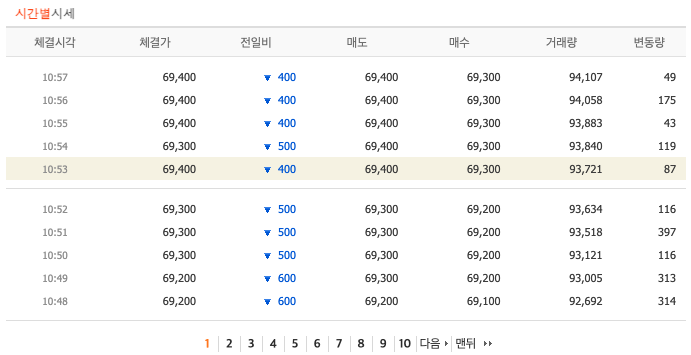

## 실습3: Naver 검색API를 이용해서 주가를 크롤링하는 동일 시간에 발생된 뉴스기사를 함께 저장하세요!

## 실습4: DB table을 만들어 Naver검색 데이터와 크롤링한 데이터를 실시간으로 저장할 수 있게 만드세요.

In [22]:
with conn.cursor() as curs:
  sql = """
  CREATE TABLE IF NOT EXISTS timely_price (
      code VARCHAR(20),
      date DATETIME,
      price BIGINT(20),
      volume BIGINT(20),
      diff BIGINT(20),
      PRIMARY KEY (code, date))
  """
  curs.execute(sql)
  curs.close()

In [23]:
df_time = read_naver_timely(251270, "넷마블")

In [25]:
df_time

,체결시각,체결가,전일비,매도,매수,거래량,변동량,day
1,10:58,58000.0,200.0,58000.0,57900.0,44313.0,55.0,20230518
2,10:57,58000.0,200.0,58000.0,57900.0,44258.0,130.0,20230518
3,10:56,58000.0,200.0,58000.0,57900.0,44128.0,68.0,20230518
4,10:55,58000.0,200.0,58000.0,57900.0,44060.0,85.0,20230518
5,10:54,57900.0,100.0,58000.0,57900.0,43975.0,76.0,20230518
9,10:53,57900.0,100.0,58000.0,57900.0,43899.0,146.0,20230518
10,10:52,57900.0,100.0,57900.0,57800.0,43753.0,55.0,20230518
11,10:51,57800.0,0.0,57900.0,57800.0,43698.0,55.0,20230518
12,10:50,57800.0,0.0,57900.0,57800.0,43643.0,112.0,20230518
13,10:49,57900.0,100.0,57900.0,57800.0,43531.0,78.0,20230518


In [26]:
with conn.cursor() as curs:
  sql = """
  DROP TABLE timely_price
  """
  curs.execute(sql)
  curs.close()
  conn.commit()

OperationalError: ignored

In [ ]:
def replace_into_db_timely(df, code, company):
  """네이버에서 분단위로 읽어온 주식 시세를 DB에 REPLACE"""
  with conn.cursor() as curs:
    for idx in range(len(df)):
      day = df.iloc[idx]["day"]
      time = df.iloc[idx]["체결시각"]
      price = df.iloc[idx]["체결가"]
      volume = df.iloc[idx]["거래량"]
      diff = df.iloc[idx]["변동량"]

      date = day+time.replace(':',"")

      sql = f"REPLACE INTO timely_price VALUES ('{code}', "\
          f"STR_TO_DATE({date}, '%Y%m%d%H%i%s'), {price}, "\
          f"{volume}, {diff})"
      curs.execute(sql)
    conn.commit()

In [27]:
replace_into_db_timely(df_time, code, "넷마블")

NameError: ignored

In [ ]:
with conn.cursor() as curs:
  sql = """
  SELECT * FROM timely_price;
  """
  curs.execute(sql)
  rows = curs.fetchall()

  curs.execute(sql)
  row = curs.fetchone()
  while row:
    print(row)
    row = curs.fetchone()
  # cursor 닫기
  curs.close()

## 실습5: 기계학습에 사용할 수 있도록 학습데이터를 가공해 보세요!
 - 입력: 긍정키워드의 검색결과 수, 부정키워드의 검색결과 수 1분전과의 가격 차이 5분전과의 가격차이 1시간 전과의 가격차이, 1분전과의 거래량차이, 5분 전과의 거래량 차이, PER, PBR 등 
   - 고려해봐야 할 점: input 데이터를 비율로 넣으면 효과적일까? 비율로 넣을때 아웃라이어가 발생하지 않을까? (예를들어 현재거라량이 100개인데 이전거래량이 10개이면 10배상승.. 현재 10000인데 이전이 5000이면 2배 상승...) 
 - 출력: 가격상승률

In [ ]:
with conn.cursor() as curs:
  sql = """
  SELECT * FROM timely_price;
  """
  df_ext = pd.read_sql_query(sql, conn)
  df_ext.to_csv(r'test.csv', index=False)

/usr/local/lib/python3.9/dist-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
df_ext

,code,date,price,volume,diff
0,251270,2023-04-05 15:57:00,69600,224498,226
